<a href="https://colab.research.google.com/github/DaVinciAyo/Waste-Classification-for-Smart-Recycling-in-UK-Cities/blob/main/Waste_Class_UK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# General libraries
import os
import json
import cv2
import random
from tqdm import tqdm

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set()

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data import AUTOTUNE


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Install and import relevant libraries
!pip install pycocotools
from pycocotools.coco import COCO

# Enable inline plotting
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the dataset
base_path = "/content/drive/MyDrive/recycling waste"

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    base_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

# View class names
print("Class names:", dataset.class_names)

Found 8368 files belonging to 9 classes.
Class names: ['batteries', 'clothes', 'e-waste', 'glass', 'light blubs', 'metal', 'organic', 'paper', 'plastic']


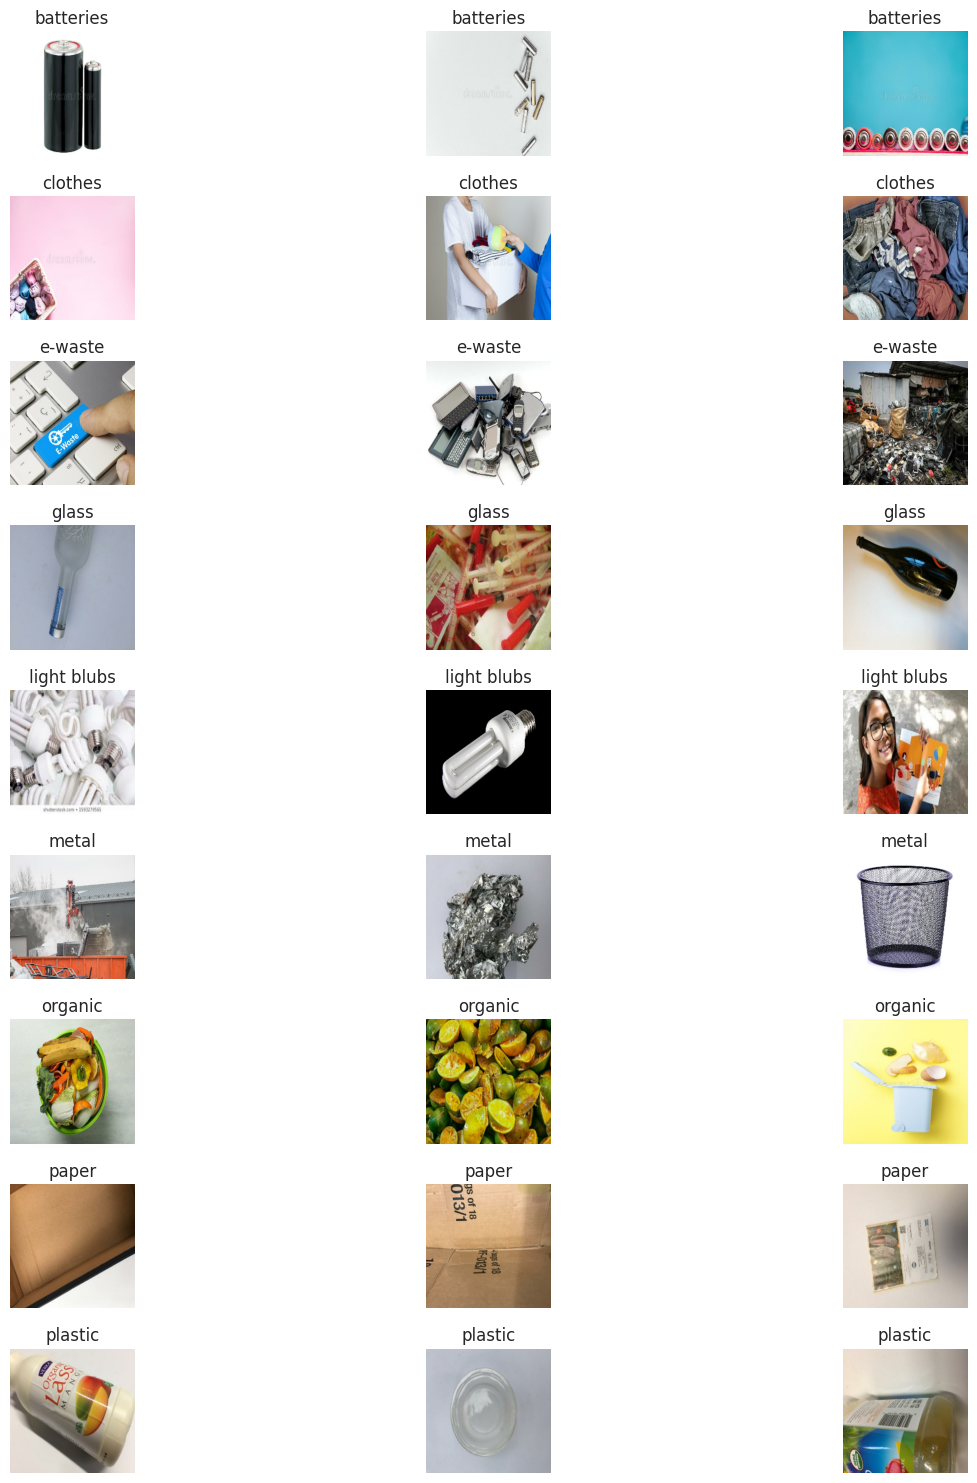

In [4]:
# Attempting to view the content of each class name

# Get class names
class_names = dataset.class_names

# Build a dictionary to collect samples for each class
samples_per_class = {class_name: [] for class_name in class_names}

# Iterate through dataset and store one image per class
for images, labels in dataset:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if len(samples_per_class[class_name]) < 3:  # Limit to 3 per class
            samples_per_class[class_name].append(img.numpy())
    if all(len(samples) >= 3 for samples in samples_per_class.values()):
        break

# Plot 3 images per class
plt.figure(figsize=(15, 15))
i = 1
for class_name, images in samples_per_class.items():
    for img in images:
        ax = plt.subplot(9, 3, i)
        plt.imshow(img.astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()


# Creating training folder

# Augment Training Data with ImageDataGenerator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Augment only training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
img_size = (224, 224)
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/MyData/test_balanced',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MyData/val_balanced',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MyData/test_balanced',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 999 images belonging to 9 classes.
Found 801 images belonging to 9 classes.
Found 999 images belonging to 9 classes.


# Check Augmented Images

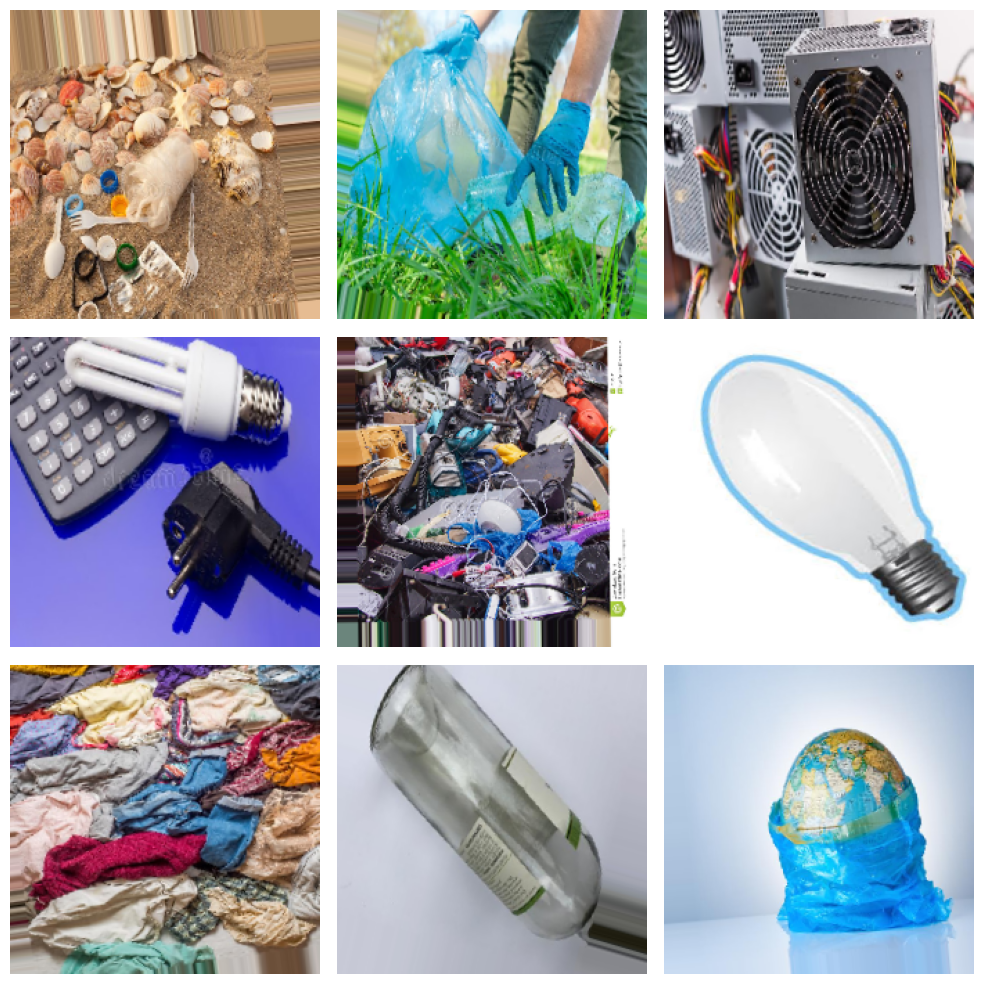

In [8]:
import matplotlib.pyplot as plt

images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


#  Load ResNet50 with Pretrained Weights

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(9, activation='softmax')  # 9 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])


In [21]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 526s 16s/step - accuracy: 0.1190 - loss: 2.9806 - val_accuracy: 0.3471 - val_loss: 1.8858
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 359s 11s/step - accuracy: 0.2493 - loss: 2.2694 - val_accuracy: 0.4806 - val_loss: 1.5224
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 353s 11s/step - accuracy: 0.3560 - loss: 1.8269 - val_accuracy: 0.6017 - val_loss: 1.2910
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 405s 13s/step - accuracy: 0.4426 - loss: 1.5897 - val_accuracy: 0.6479 - val_loss: 1.1516
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 404s 13s/step - accuracy: 0.4968 - loss: 1.4696 - val_accuracy: 0.6654 - val_loss: 1.0746


In [23]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test accuracy: {test_acc:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step - accuracy: 0.7143 - loss: 0.9233
Test accuracy: 0.6977


In [24]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

img_size = (224, 224)

def preprocess_image(image_path):
    img = Image.open(image_path).resize(img_size)
    img_array = np.array(img)

    # Remove alpha channel if present
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]

    img_array = densenet_preprocess(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


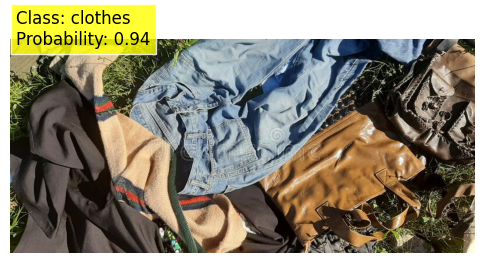

batteries: 0.0003
clothes: 0.9392
e-waste: 0.0144
glass: 0.0007
light blubs: 0.0058
metal: 0.0031
organic: 0.0251
paper: 0.0038
plastic: 0.0077


In [25]:
image_path ='/content/drive/MyDrive/recycling waste/clothes/abandoned-clothes-background-looking-down-piles-colourful-old-discarded-ground-informal-rubbish-dump-174236657.jpg'
img=preprocess_image(image_path)
prediction = model.predict(img)
predicted_class_index =np.argmax(prediction[0])
predicted_class = class_names[predicted_class_index]
probability = prediction[0][predicted_class_index]

#Display the image with prediction
plt.figure(figsize=(6,6))
plt.imshow(Image.open(image_path))
plt.axis('off')

#Add test with class and probability
plt.text(10,10, f'Class: {predicted_class}\nProbability: {probability:.2f}', bbox=dict(facecolor='yellow', alpha=0.8), fontsize=12, color='black')

#Save/show plot
plt.savefig('prediction_result.png')
plt.show()

for i, class_name in enumerate(class_names):
  print(f"{class_name}: {prediction[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


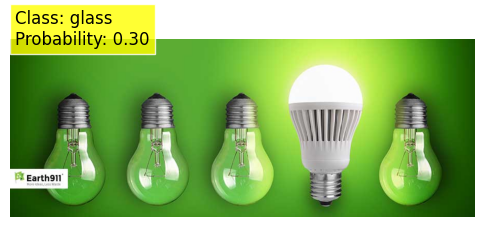

batteries: 0.1359
clothes: 0.0269
e-waste: 0.0550
glass: 0.3017
light blubs: 0.2119
metal: 0.0175
organic: 0.1737
paper: 0.0169
plastic: 0.0605


In [26]:
image_path ='//content/drive/MyDrive/recycling waste/light blubs/AdobeStock_61932077-small.jpg'
img=preprocess_image(image_path)
prediction = model.predict(img)
predicted_class_index =np.argmax(prediction[0])
predicted_class = class_names[predicted_class_index]
probability = prediction[0][predicted_class_index]

#Display the image with prediction
plt.figure(figsize=(6,6))
plt.imshow(Image.open(image_path))
plt.axis('off')

#Add test with class and probability
plt.text(10,10, f'Class: {predicted_class}\nProbability: {probability:.2f}', bbox=dict(facecolor='yellow', alpha=0.8), fontsize=12, color='black')

#Save/show plot
plt.savefig('prediction_result.png')
plt.show()

for i, class_name in enumerate(class_names):
  print(f"{class_name}: {prediction[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


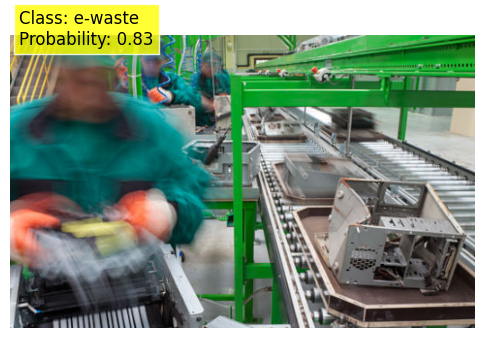

batteries: 0.0461
clothes: 0.0178
e-waste: 0.8341
glass: 0.0032
light blubs: 0.0174
metal: 0.0137
organic: 0.0138
paper: 0.0167
plastic: 0.0372


In [27]:
image_path ='/content/drive/MyDrive/recycling waste/e-waste/Recyclingelec517.jpg'
img=preprocess_image(image_path)
prediction = model.predict(img)
predicted_class_index =np.argmax(prediction[0])
predicted_class = class_names[predicted_class_index]
probability = prediction[0][predicted_class_index]

#Display the image with prediction
plt.figure(figsize=(6,6))
plt.imshow(Image.open(image_path))
plt.axis('off')

#Add test with class and probability
plt.text(10,10, f'Class: {predicted_class}\nProbability: {probability:.2f}', bbox=dict(facecolor='yellow', alpha=0.8), fontsize=12, color='black')

#Save/show plot
plt.savefig('prediction_result.png')
plt.show()

for i, class_name in enumerate(class_names):
  print(f"{class_name}: {prediction[0][i]:.4f}")

In [ ]:
model.save('my_model.h5')

In [ ]:
!pip install -U transformers

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

model = tf.keras.models.load_model(
    "/content/my_model.h5",
    custom_objects={'KerasLayer': hub.KerasLayer}
)

class_names = ['batteries', 'clothes', 'e-waste', 'glass', 'light blubs',
               'metal', 'organic', 'paper', 'plastic']
IMG_SIZE = 224

def preprocess_image(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return tf.expand_dims(image, axis=0)

def predict_waste(image):
    try:
        processed = preprocess_image(image)
        preds = model.predict(processed, verbose=0)
        label = class_names[np.argmax(preds)]
        confidence = float(np.max(preds))
        return f"{label} ({confidence:.2f})"
    except Exception as e:
        return f"Error: {str(e)}"

examples = [
    ["/content/drive/MyDrive/recycling waste/e-waste/1-consumerelec.jpg"],
    ["/content/drive/MyDrive/recycling waste/e-waste/african-men-disassemble-electronic-scrap-and-bulky-waste-on-the-picture-id1149420463.jpg"],
    ["/content/drive/MyDrive/recycling waste/batteries/9-volt-battery-white-clipping-path-11607399.jpg"]
]

iface = gr.Interface(
    fn=predict_waste,
    inputs=gr.Image(type="numpy", label="Upload a Waste Image"),
    outputs="text",
    title="Waste Image Classifier",
    description="Classify an image into one of 9 waste categories.",
    examples=examples
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fca03e5fd896b5e9fc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
